In [1]:
import torch
from torchinfo import summary
from torchvision import transforms
from matplotlib import pyplot as plt

from networks_medium import Encoder, Decoder
from Autoencoders import Autoencoder
from data import CelebA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


device(type='cuda', index=1)

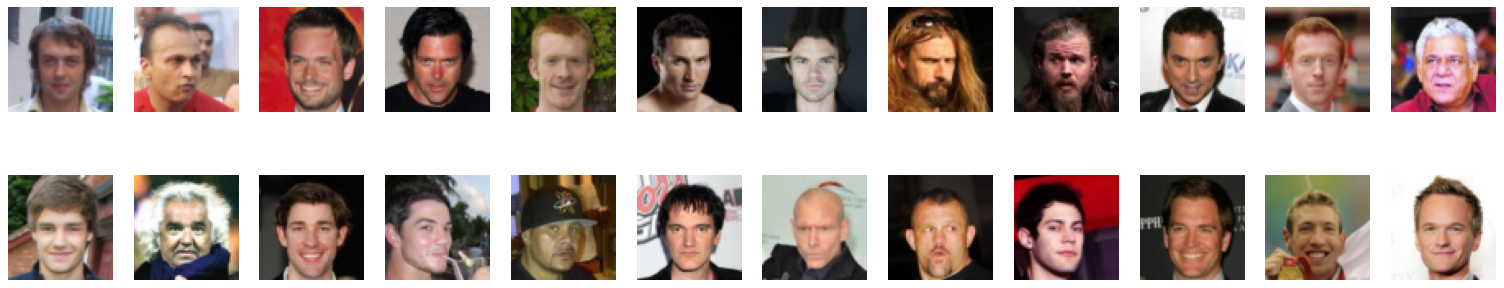

In [2]:
transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])

# show 2 rows of 12 images from train dataset
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(train_dataset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [3]:
z_dim = 1024
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 3

encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)
encoder._build_fc_if_needed(16, 16)
decoder._build_fc_if_needed(16, 16)

In [4]:
autoencoder = Autoencoder(encoder, decoder).to(device)


from vgg_perceptual_loss import VGGPerceptualLoss
autoencoder.reconstruction_loss = VGGPerceptualLoss().to(device)

In [5]:
bs = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)

In [6]:
# If you want to load a model from checkpoint, uncomment the following lines:

# conformal_autoencoder.encoder._build_fc_if_needed(16,16)
# conformal_autoencoder.decoder._build_fc_if_needed(16,16)
# conformal_autoencoder.load_model_from_checkpoint("models/path.pth")

In [7]:
# if you want to load optimizer and scheduler state from checkpoint, uncomment the following lines (and include optimizer and scheduler in train_model call):

# optimizer = torch.optim.Adam(conformal_autoencoder.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
# optimizer.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_optimizer.pth"))
# scheduler.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_scheduler.pth"))


In [8]:
epochs = 400
optimizer, scheduler = autoencoder.train_model(train_loader,
                                                         val_loader,
                                                         has_label=True,
                                                         epochs=epochs,
                                                         batch_size=bs,
                                                         learning_rate=1e-3,
                                                         val_every=10,
                                                         scheduler_kwargs={"step_size":20, "gamma":0.85}
                                                         )

Epoch [10/400], Validation Loss: 1.19163036


Epoch [20/400], Validation Loss: 1.16048002


Epoch [30/400], Validation Loss: 1.12127006


Epoch [40/400], Validation Loss: 1.11442482


Epoch [50/400], Validation Loss: 1.10302126


Epoch [60/400], Validation Loss: 1.10340035


Epoch [70/400], Validation Loss: 1.09335470


Epoch [80/400], Validation Loss: 1.08994651


Epoch [90/400], Validation Loss: 1.08645594


Epoch [100/400], Loss: 1.08482158


Epoch [100/400], Validation Loss: 1.08314419


Epoch [110/400], Validation Loss: 1.09173918


Epoch [120/400], Validation Loss: 1.07957637


Epoch [130/400], Validation Loss: 1.07790411


Epoch [140/400], Validation Loss: 1.08092296


Epoch [150/400], Validation Loss: 1.07449734


Epoch [160/400], Validation Loss: 1.07501137


Epoch [170/400], Validation Loss: 1.07830799


Epoch [180/400], Validation Loss: 1.07528782


Epoch [190/400], Validation Loss: 1.07100379


Epoch [200/400], Loss: 1.06886756


Epoch [200/400], Validation Loss: 1.07087195


Epoch [210/400], Validation Loss: 1.06913102


Epoch [220/400], Validation Loss: 1.06913984


Epoch [230/400], Validation Loss: 1.06837463


Epoch [240/400], Validation Loss: 1.06714833


Epoch [250/400], Validation Loss: 1.06628060


Epoch [260/400], Validation Loss: 1.06629479


Epoch [270/400], Validation Loss: 1.06785798


Epoch [280/400], Validation Loss: 1.06610990


Epoch [290/400], Validation Loss: 1.06495810


Epoch [300/400], Loss: 1.06207776


Epoch [300/400], Validation Loss: 1.06497693


Epoch [310/400], Validation Loss: 1.06394875


Epoch [320/400], Validation Loss: 1.06419885


Epoch [330/400], Validation Loss: 1.06344104


Epoch [340/400], Validation Loss: 1.06334567


Epoch [350/400], Validation Loss: 1.06351495


Epoch [360/400], Validation Loss: 1.06309390


Epoch [370/400], Validation Loss: 1.06241834


Epoch [380/400], Validation Loss: 1.06258619


Epoch [390/400], Validation Loss: 1.06268752


Epoch [400/400], Loss: 1.05893302


Epoch [400/400], Validation Loss: 1.06224501


In [9]:
autoencoder.save_checkpoint("models/celeba_autoencoder_v1_3.pth") # z_dim = 1024, Perceptual Loss

Checkpoint saved to models/celeba_autoencoder_v1_3.pth at epoch 401


In [10]:
torch.save(optimizer.state_dict(), "models/celeba_autoencoder_v1_3_optimizer.pth")
torch.save(scheduler.state_dict(), "models/celeba_autoencoder_v1_3_scheduler.pth")

In [11]:
#get current learning rate
for param_group in optimizer.param_groups:
    current_lr = param_group['lr']
    break
print(f"Current learning rate: {current_lr}")

Current learning rate: 3.875953108451434e-05


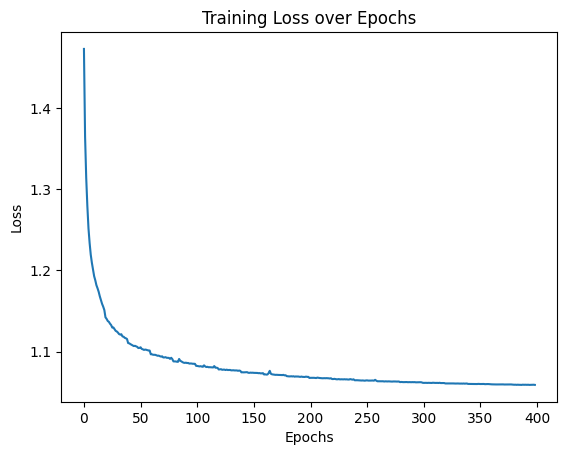

In [12]:
plt.plot(autoencoder.metrics_list["reconstruction_loss"][1:], label="Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

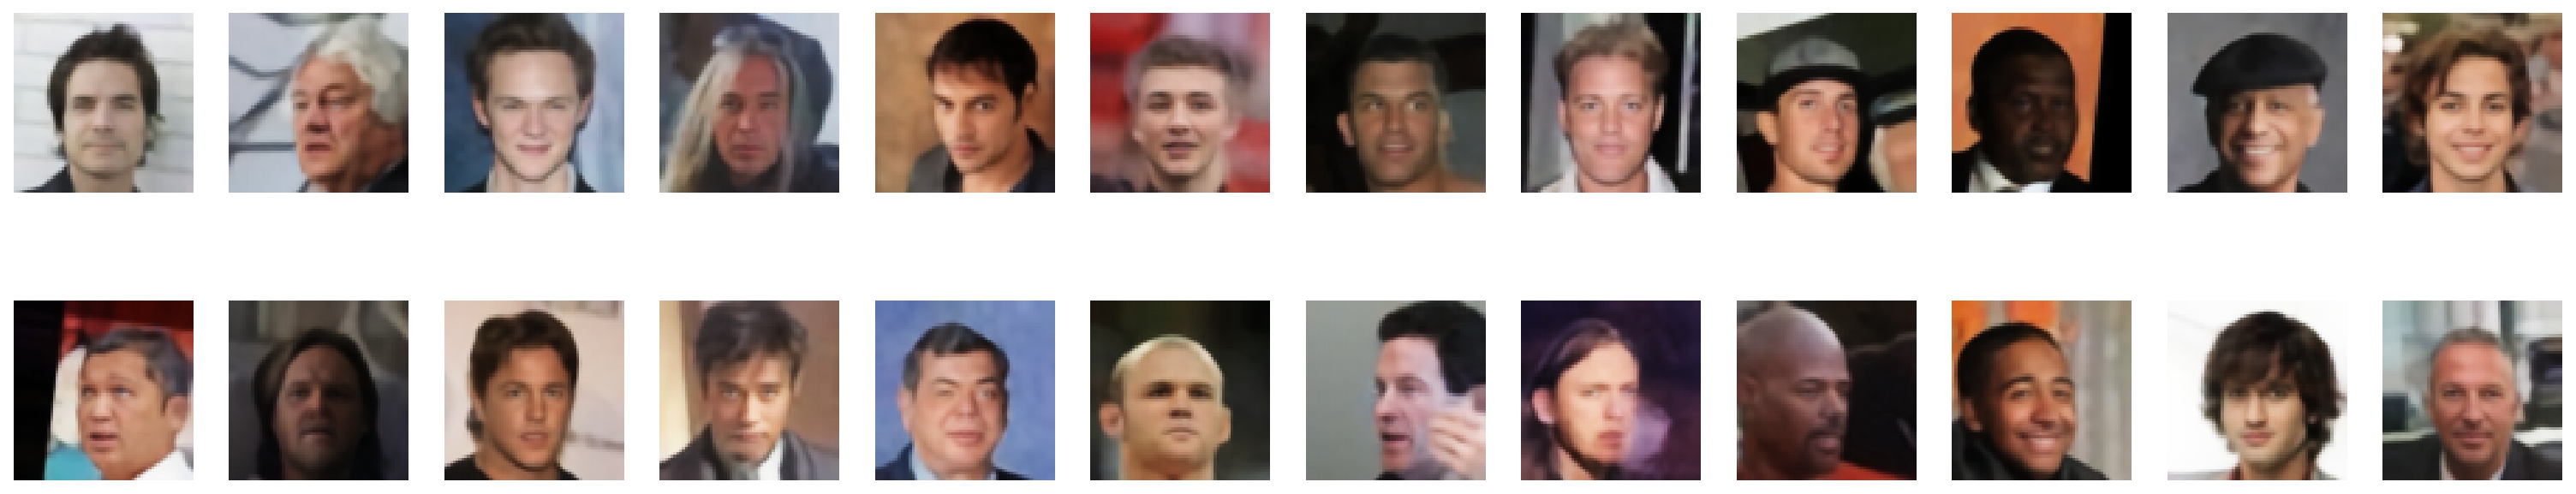

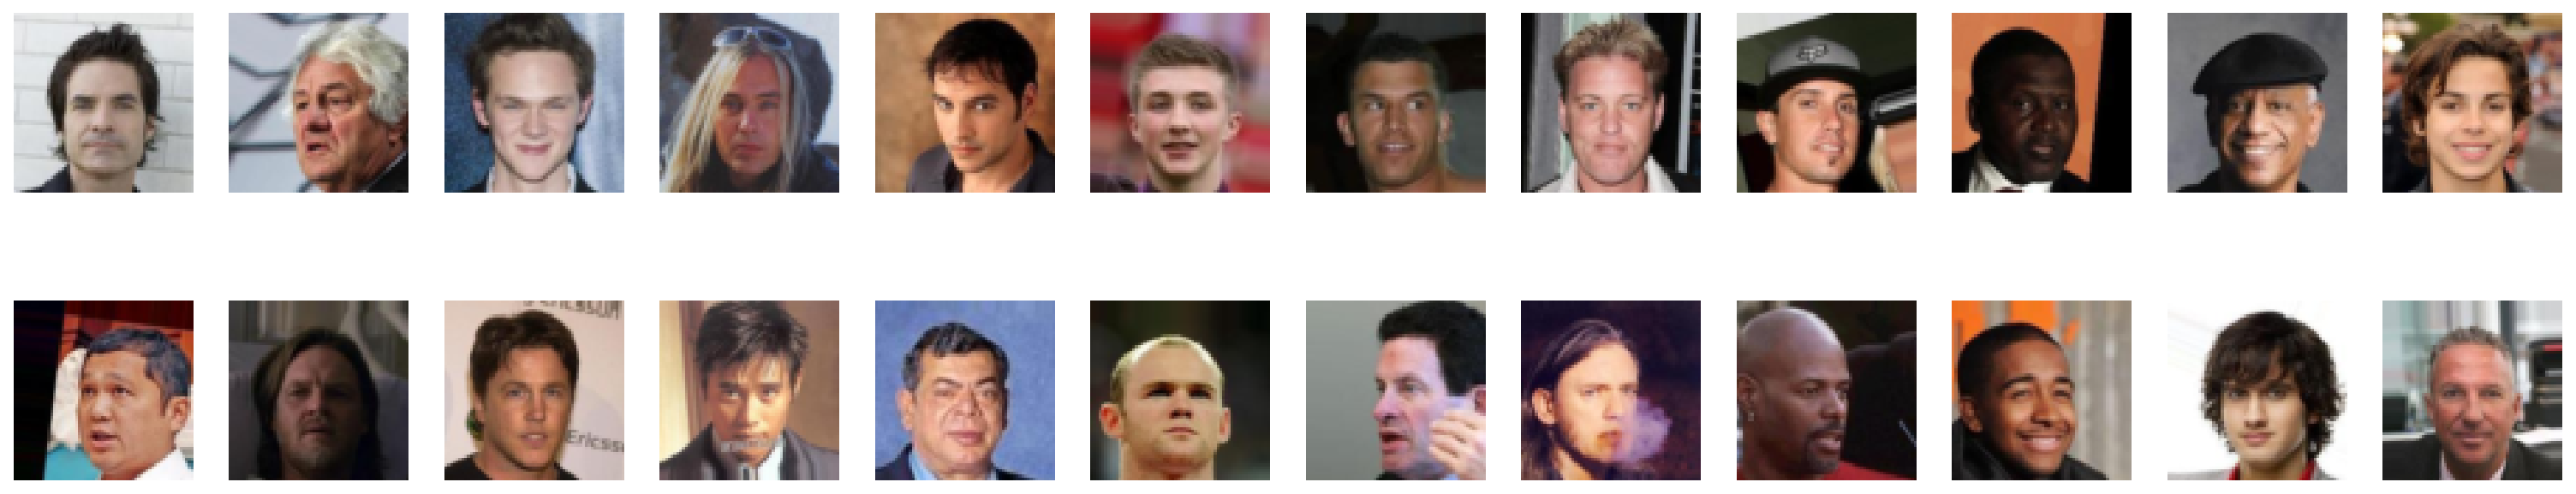

In [13]:
samples = autoencoder.forward(val_dataset.get_sample(24, seed=32)[0].to(device))
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(samples[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(val_dataset.get_sample(24, seed=32)[0][i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

In [15]:
from metrics_copy import evaluate_conformality

evaluate_conformality(autoencoder, val_dataset.get_sample(200, seed=42)[0].to(device), chunk_size=64)

tensor([0., -0., -0., -0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0., -0., 0., -0., 0., 0., -0., 0., -0.,
        -0., -0., -0., 0., 0., 0., -0., -0., -0., -0., 0., 0., -0., -0., -0., -0., -0., -0., -0., -0., -0., 0., -0., -0.,
        -0., -0., 0., -0., -0., -0., -0., -0., 0., 0., 0., -0., -0., 0., 0., -0., -0., -0., 0., 0., 0., 0., 0., -0.,
        -0., 0., 0., 0., -0., -0., -0., -0., -0., 0., -0., 0., 0., 0., -0., 0., -0., -0., -0., 0., 0., -0., -0., 0.,
        0., 0., -0., -0., 0., -0., 0., 0., 0., 0., 0., 0., -0., -0., -0., 0., -0., 0., -0., -0., 0., -0., -0., -0.,
        -0., -0., 0., -0., 0., -0., 0., 0., -0., 0., -0., 0., -0., -0., 0., 0., 0., -0., 0., -0., 0., 0., -0., -0.,
        -0., 0., -0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., 0., -0., -0., 0., 0., -0., -0., 0., 0., -0., 0.,
        -0., -0., 0., -0., -0., -0., 0., -0., 0., 0., -0., -0., -0., -0., -0., 0., -0., 0., 0., -0., -0., 0., 0., 0.,
        -0., 0., -0., -0., -0., -0., -0., 0.], device='cuda:1',
  

{'Reconstruction Error': 0.0016593752661719918,
 'Diagonal Uniformity (gini)': 0.12324443459510803,
 'Conformal Factor Mean': 1.1710996627807617,
 'Conformal Factor Std': 0.2934120297431946,
 'Conformal Factor Std (normalized)': 0.2505440413951874,
 'Conformal Factor Estimate Error': 0.031515832990407944,
 'Conformal Factor Estimate Error (normalized)': 0.026911312714219093,
 'Off-diagonal Mean': 0.08986294269561768,
 'Off-diagonal Mean (normalized)': 0.07809847593307495,
 'Off-diagonal Norm': 121.92640686035156,
 'Off-diagonal Norm (normalized)': 105.71761322021484,
 'Conformality Mean': 0.09006212651729584,
 'Conformality Mean (normalized)': 0.07826784253120422,
 'Conformality Norm': 122.26416015625,
 'Conformality Norm (normalized)': 105.99681091308594,
 'Determinant Estimation Error': 7.6282747961547785e+143,
 'Determinant Estimation Error (normalized)': 6.3990606981222344e+150,
 'Determinant Estimation from Estimate Error': 3.744766746550111e+137,
 'Determinant Estimation from Est